In [2]:
import torch
import torchvision
from torchsummary import summary
import numpy as np
import os
import matplotlib.pyplot as plt

LEARNING_RATE = 0.001
EPOCHS = 10
BATCH_SIZE = 128

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

device: cuda


In [4]:
train_dataset = torchvision.datasets.MNIST('./', train=True, download=True)
test_dataset = torchvision.datasets.MNIST('./', train=False)

In [5]:
x_train_orig = train_dataset.train_data
y_train_orig = train_dataset.train_labels
x_test_orig = test_dataset.test_data
y_test_orig = test_dataset.test_labels

print('x_train_orig shape: ', x_train_orig.shape)
print('y_train_orig shape: ', y_train_orig.shape)
print('x_test_orig shape: ', x_test_orig.shape)
print('y_test_orig shape: ', y_test_orig.shape)

x_train_orig shape:  torch.Size([60000, 28, 28])
y_train_orig shape:  torch.Size([60000])
x_test_orig shape:  torch.Size([10000, 28, 28])
y_test_orig shape:  torch.Size([10000])


/home/changjun/anaconda3/lib/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/changjun/anaconda3/lib/python3.10/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/changjun/anaconda3/lib/python3.10/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/changjun/anaconda3/lib/python3.10/site-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [6]:
x_train = (x_train_orig[10000:] / 255.).view(-1, 1, 28, 28).to(device=device)
y_train = y_train_orig[10000:].to(device=device)
x_val = (x_train_orig[:10000] / 255.).view(-1, 1, 28, 28).to(device=device)
y_val = y_train_orig[:10000].to(device=device)
x_test = (x_test_orig / 255.).view(-1, 1, 28, 28).to(device=device)
y_test = y_test_orig.to(device=device)

print('x_train shape : ', x_train.shape)
print('y_train shape : ', y_train.shape)
print('x_train shape : ', x_val.shape)
print('y_train shape : ', y_val.shape)
print('x_test  shape : ', x_test.shape)
print('y_test  shape : ', y_test.shape)

x_train shape :  torch.Size([50000, 1, 28, 28])
y_train shape :  torch.Size([50000])
x_train shape :  torch.Size([10000, 1, 28, 28])
y_train shape :  torch.Size([10000])
x_test  shape :  torch.Size([10000, 1, 28, 28])
y_test  shape :  torch.Size([10000])


In [7]:
training_set = torch.utils.data.TensorDataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
class MnistCNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, 3, 1, 1)
        self.conv2 = torch.nn.Conv2d(32, 64, 3, 1, 1)
        self.fc = torch.nn.Linear(7 * 7 * 64, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, 2)
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, 2)
        x = torch.nn.Flatten()(x)
        x = self.fc(x)
        return x

In [9]:
model = MnistCNN().to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE)

optimizer.zero_grad()

In [10]:
for epoch in range(EPOCHS):
    total_loss = 0
    
    for xs, ys in train_loader:
        pred = model(xs)
        loss = criterion(pred, ys)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        total_loss += loss.item()
    
    with torch.no_grad():
        pred = model(x_val)
        accuracy = pred.data.max(1)[1].eq(y_val.data).sum() / len(x_val) * 100
        loss = criterion(pred, y_val)
    
    print(f'[Epoch: {epoch+1:>2}] Validation Loss: {loss:>.6f} Validation Accuracy: {accuracy:>.2f} %')

[Epoch:  1] Validation Loss: 0.090684 Validation Accuracy: 97.23 %
[Epoch:  2] Validation Loss: 0.068558 Validation Accuracy: 97.98 %
[Epoch:  3] Validation Loss: 0.057894 Validation Accuracy: 98.23 %
[Epoch:  4] Validation Loss: 0.064758 Validation Accuracy: 98.08 %
[Epoch:  5] Validation Loss: 0.046165 Validation Accuracy: 98.72 %
[Epoch:  6] Validation Loss: 0.051907 Validation Accuracy: 98.59 %
[Epoch:  7] Validation Loss: 0.047951 Validation Accuracy: 98.56 %
[Epoch:  8] Validation Loss: 0.066493 Validation Accuracy: 98.14 %
[Epoch:  9] Validation Loss: 0.045804 Validation Accuracy: 98.74 %
[Epoch: 10] Validation Loss: 0.044120 Validation Accuracy: 98.85 %


In [11]:
with torch.no_grad():
    y_pred = model(x_test)
    accuracy = y_pred.data.max(1)[1].eq(y_test.data).sum() / len(x_test) * 100
    print(f'{accuracy:>.2f} %')

98.97 %


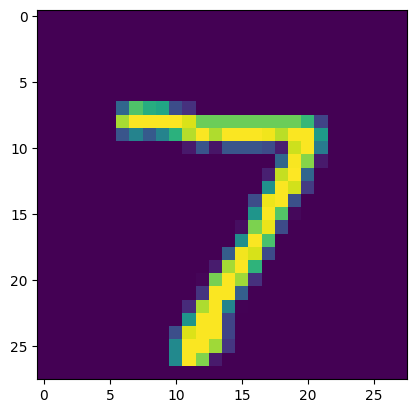

label: 7 (0.9999986886978149)


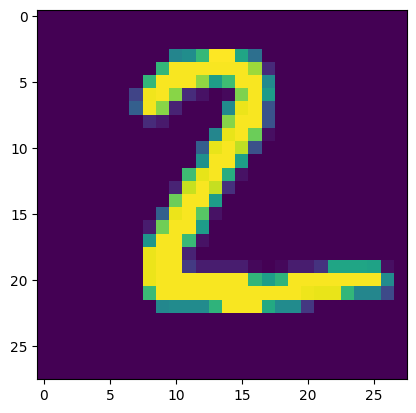

label: 2 (1.0)


In [12]:
# display result

x = x_test[0].reshape(-1, 1, 28, 28)
y = y_test[0]

y_pred = model(x).to('cpu')

plt.imshow(x.to('cpu').view(28,28))
plt.show()
label = y_pred.max(1)[1].item()
print(f"label: {label} ({torch.nn.functional.softmax(y_pred[0], dim=0)[label]})")

x = x_test[1].reshape(-1, 1, 28, 28)
y = y_test[1]

y_pred = model(x).to('cpu')

plt.imshow(x.to('cpu').view(28,28))
plt.show()
label = y_pred.max(1)[1].item()
print(f"label: {label} ({torch.nn.functional.softmax(y_pred[0], dim=0)[label]})")

In [13]:
os.makedirs('params', exist_ok=True)

# extract weight and bias to binary file
parameters = model.parameters()

conv1_weight = next(parameters).to('cpu').detach().numpy()
with open('params/conv1_weight.bin', 'wb') as f:
    f.write(conv1_weight.tobytes())
    
conv1_bias = next(parameters).to('cpu').detach().numpy()
with open('params/conv1_bias.bin', 'wb') as f:
    f.write(conv1_bias.tobytes())

conv2_weight = next(parameters).to('cpu').detach().numpy()
with open('params/conv2_weight.bin', 'wb') as f:
    f.write(conv2_weight.tobytes())

conv2_bias = next(parameters).to('cpu').detach().numpy()
with open('params/conv2_bias.bin', 'wb') as f:
    f.write(conv2_bias.tobytes())

fc_weight = next(parameters).to('cpu').detach().numpy()
with open('params/fc_weight.bin', 'wb') as f:
    f.write(fc_weight.tobytes())
    
fc_bias = next(parameters).to('cpu').detach().numpy()
with open('params/fc_bias.bin', 'wb') as f:
    f.write(fc_bias.tobytes())

In [14]:
os.makedirs('digits', exist_ok=True)

for i in range(10):
    idx = np.argwhere(y_test.to('cpu').numpy() == i)[0].item()
    x = x_test[idx].to('cpu').detach().numpy()
    with open(f'digits/{i}.bin', 'wb') as f:
        f.write(x.tobytes())

In [15]:
print(torch.__version__)

2.0.1+cu118


In [18]:
# Export ONNX
dummy_input = torch.randn(1,1,28,28, device=device)
torch.onnx.export(
    model,
    dummy_input,
    "mnist_cnn_dynamic.onnx",
    input_names=["input"],
    output_names=["output"],
    verbose=True,
    dynamic_axes={
        "input": [0]
    })

Exported graph: graph(%input : Float(*, 1, 28, 28, strides=[784, 784, 28, 1], requires_grad=0, device=cuda:0),
      %conv1.weight : Float(32, 1, 3, 3, strides=[9, 9, 3, 1], requires_grad=1, device=cuda:0),
      %conv1.bias : Float(32, strides=[1], requires_grad=1, device=cuda:0),
      %conv2.weight : Float(64, 32, 3, 3, strides=[288, 9, 3, 1], requires_grad=1, device=cuda:0),
      %conv2.bias : Float(64, strides=[1], requires_grad=1, device=cuda:0),
      %fc.weight : Float(10, 3136, strides=[3136, 1], requires_grad=1, device=cuda:0),
      %fc.bias : Float(10, strides=[1], requires_grad=1, device=cuda:0)):
  %/conv1/Conv_output_0 : Float(*, 32, 28, 28, strides=[25088, 784, 28, 1], requires_grad=0, device=cuda:0) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1], onnx_name="/conv1/Conv"](%input, %conv1.weight, %conv1.bias), scope: __main__.MnistCNN::/torch.nn.modules.conv.Conv2d::conv1 # /home/changjun/anaconda3/lib/python3.10/site-packa